In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import clear_output
from tqdm import tqdm


import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torchvision
from torchvision import transforms

%matplotlib inline

device = torch.device('cuda')

In [2]:
class ResidualSeparableBlock(nn.Module):
    def __init__(self, features, kernel=3, padding=1, padding_mode='reflect', **kwargs):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                features,
                features,
                kernel,
                padding=padding,
                padding_mode=padding_mode,
                groups=features,
                **kwargs
            ),
            nn.Conv2d(features, features, 1, bias=False),
            nn.InstanceNorm2d(features, affine=True),
            nn.ReLU(),
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(
                features,
                features,
                kernel,
                padding=padding,
                padding_mode=padding_mode,
                groups=features,
                **kwargs
            ),
            nn.Conv2d(features, features, 1, bias=False),
            nn.InstanceNorm2d(features, affine=True),
        )

    def forward(self, x):
        return self.conv_2(self.conv_1(x)) + x


def conv_separable_block(in_features, out_features, kernel=3, stride=2, padding=1, padding_mode='reflect', **kwargs):
    mid_features = out_features // in_features * in_features
    return nn.Sequential(
        nn.Conv2d(
            in_features,
            mid_features,
            kernel,
            stride=stride,
            padding=padding,
            padding_mode=padding_mode,
            groups=in_features,
            **kwargs
        ),
        nn.Conv2d(mid_features, out_features, 1, bias=False),
        nn.InstanceNorm2d(out_features, affine=True),
        nn.ReLU(),
    )


def upconv_separable_block(in_features, out_features, bias=True, kernel=3, stride=2, padding=1, output_padding=1, **kwargs):
    mid_features = in_features // out_features * out_features
    return nn.Sequential(
        nn.ConvTranspose2d(in_features, mid_features, 1),
        nn.ConvTranspose2d(
            mid_features,
            out_features,
            kernel,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
            groups=out_features,
            bias=bias,
            **kwargs
        ),
    )


class Activate(nn.Module):
    def forward(self, input: torch.Tensor):
        # return input.clamp(0.0, 1.0)
        return input.tanh().add(1).true_divide(2)


class StyleTransferFast3(nn.Module):
    def __init__(self, n_residual=15):
        super().__init__()
        self.n_residual = n_residual
        residual_stack = [ResidualSeparableBlock(64) for _ in range(self.n_residual)]
        self.layers = nn.Sequential(
            conv_separable_block(3, 16),
            conv_separable_block(16, 64),
            *residual_stack,
            upconv_separable_block(64, 16),
            nn.ReLU(),
            upconv_separable_block(16, 3),
            Activate()
        )

    def forward(self, x):
        return self.layers(x)

class ImageDataset(Dataset):
    def __init__(self, paths):
        self._paths = paths
        self._toTensor = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        with Image.open(self._paths[index]) as img:
            sample = img.convert('RGB')
        sample = self._toTensor(sample)
        return sample

    def __len__(self):
        return len(self._paths)


def criterion(outputs, inputs):
    return outputs.sub(inputs).pow(2).mean()


def run_batches(lr_sched, epoch, do_train):
    with torch.set_grad_enabled(do_train):
        model.train(do_train)
        running_loss = 0.0
        processed_count = 0
        opt = lr_sched.optimizer

        batches = tqdm(
            loader,
            desc=('Train E{}' if do_train else 'Validate E{}').format(epoch),
            unit='batch',
            leave=False
        )
        for inputs in batches:
            this_batch_size = inputs.size(0)
            inputs = inputs.to(device)

            with torch.autograd.set_detect_anomaly(False):
                outputs = model(inputs)
                loss_value = criterion(outputs, inputs)
                if do_train:
                    opt.zero_grad()
                    loss_value.backward()
                    opt.step()
            running_loss += loss_value.item() * this_batch_size
            processed_count += this_batch_size
        #if not do_train:
        lr_sched.step(running_loss / processed_count)

    return running_loss / processed_count


def imshow(inp, title=None, plt_ax=plt):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0)).clip(0, 1)
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


def train(epochs = 40, init_lr=1E-3):
    opt = torch.optim.AdamW(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=init_lr,
    )
    lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt,
        factor=0.5,
        patience=2,
        threshold=1e-1,
        verbose=True
    )
    for epoch in range(0, epochs):
        epoch += 1
        loss = run_batches(
            lr_sched,
            epoch,
            True,
        )
        print(f"Epoch {epoch}, loss {loss}")
    return


In [17]:
files = sorted(list(Path("/home/master/Downloads/coco-square").rglob('*.jpg')))
dataset = ImageDataset(files)
loader = DataLoader(
    dataset,
    sampler=RandomSampler(files),
    batch_size=16,
    num_workers=4,
    pin_memory=True,
)
model = nn.Sequential(
    conv_separable_block(3, 16),
    conv_separable_block(16, 64),
    upconv_separable_block(64, 16),
    nn.ReLU(),
    upconv_separable_block(16, 3),
    Activate()
)
model.to(device);

In [18]:
train(10, init_lr=1E-2)

Epoch 1, loss 0.01643040388226509
Epoch 2, loss 0.009561334906518459
Epoch 3, loss 0.007995180446654558
Epoch 4, loss 0.007165852861106396
Epoch 5, loss 0.006828044779598713
Epoch 6, loss 0.006373650769889354
Epoch 7, loss 0.006049247905611992
Epoch 8, loss 0.0057618523560464385
Epoch 9, loss 0.005577728944271803
Epoch 10, loss 0.005451498593389988


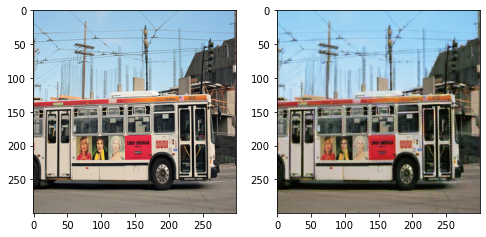

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
random_character = int(np.random.uniform(0, len(dataset)))
im_val = dataset[random_character]
# im_val = torch.zeros((3,150,150))
# im_val[0] = 1.0
imshow(im_val, plt_ax=ax[0])
im_converted = model(im_val.unsqueeze(0).to(device)).detach().cpu().squeeze(0)
imshow(im_converted, plt_ax=ax[1])
transforms.ToPILImage()(im_converted).save("tw.png")

In [6]:
for m in model.modules():
    print(m)

Sequential(
  (0): Conv2d(3, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, padding_mode=reflect)
  (1): Conv2d(15, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (2): ConvTranspose2d(16, 15, kernel_size=(1, 1), stride=(1, 1))
  (3): ConvTranspose2d(15, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), groups=3)
  (4): Activate()
)
Conv2d(3, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, padding_mode=reflect)
Conv2d(15, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
ConvTranspose2d(16, 15, kernel_size=(1, 1), stride=(1, 1))
ConvTranspose2d(15, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), groups=3)
Activate()


In [19]:
im_val = torch.ones(15,2,2)
im_converted = list(model.modules())[3](im_val.unsqueeze(0).to(device)).detach().cpu().squeeze(0)

In [20]:
from io import open
from struct import Struct

weights = []
align_to_4byte_numbers = 64
for m in model.modules():
    numel = 0
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        wanted_bias_len = m.weight.data.size()[0]
        if isinstance(m, nn.ConvTranspose2d) and wanted_bias_len == m.weight.data.size()[1]:
            weights.append(m.weight.data.permute((1, 0, 2, 3)))
        else:
            weights.append(m.weight.data)
        numel = weights[-1].numel() + wanted_bias_len
        if m.bias is not None:
            weights.append(m.bias.data)
            bias_len = weights[-1].numel()
            if wanted_bias_len > bias_len:
                weights.append(torch.zeros((wanted_bias_len - bias_len,)))
        else:
            weights.append(torch.zeros((wanted_bias_len,)))
    elif isinstance(m, nn.InstanceNorm2d):
        if m.bias is not None:
            weights.append(m.weight.data)
            numel = weights[-1].numel()
            weights.append(m.bias.data)
            numel += weights[-1].numel()
    numel = numel % align_to_4byte_numbers
    if numel % align_to_4byte_numbers > 0:
        weights.append(torch.zeros((align_to_4byte_numbers - numel,)))


ff = Struct("f")
with open("/home/master/src/VkStyleLayer/config/weights.bin", "wb") as f:
    for t in weights:
        for num in t.detach().cpu().flatten():
            f.write(ff.pack(num))